<a href="https://colab.research.google.com/github/Lightning51B/Caltech-AI-ML/blob/main/CNN_for_Flowers_Image_Classification_20250403.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *CNN* for Flowers Image Classification

In [ ]:
images_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

In [ ]:
from tensorflow.keras import layers, models, utils, Sequential, losses
from tensorflow import data
import os #for dir & os operations
import pathlib #for dir operations
import PIL #for viewing images
import matplotlib.pyplot as plt #for plots



In [ ]:
data_dir = utils.get_file('flower_photos',
                          origin=images_url,
                          untar=True)# to unzip the tar file

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [ ]:
data_dir = pathlib.Path(data_dir)
#data_dir = str(data_dir) +'/flower_photos'

In [ ]:
#view a list of files/images

list(data_dir.glob('**/*.jpg')) #give me all folders and subfolder with .jpg files

[PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflowers/4933822272_79af205b94.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflowers/40410814_fba3837226_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflowers/417251603_69f0ee57a9_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflowers/2575272111_f04d79b9af_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflowers/15054750690_198b6ab0f2_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflowers/4869189730_f47c124cda_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflowers/2816503473_580306e772.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflowers/19519101829_46af0b4547_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflowers/8174970894_7f9a26be7e.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflower

In [ ]:
roses_images = list(data_dir.glob('*/roses/*.jpg'))
roses_images

[PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/12450781274_eb78723921.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/8437935944_aab997560a_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/483444865_65962cea07_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/7147367479_f7a6ef0798.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/3026375835_a20ecdd140_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/9614492283_66020fb4eb_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/3872230296_6c477309f3_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/1469726748_f359f4a8c5.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/459042023_6273adc312_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses/3494252600_29f26e3ff0_n.jpg'),
 PosixPath('/root

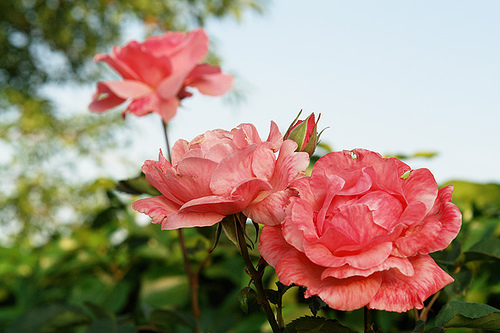

In [ ]:
PIL.Image.open(roses_images[60])

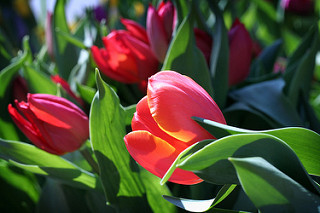

In [ ]:
PIL.Image.open(list(data_dir.glob('*/tulips/*.jpg'))[15])

## Splitting The Dataset into Train and Test Data

In [ ]:
vs = 0.2 #validation split
#choose a consistent image size
imgs_h = 180
imgs_w = 180

batch_s = 32
my_seed = 100 #similar to train test split random state


In [ ]:
training_data = utils.image_dataset_from_directory(directory=str(data_dir)+'/flower_photos',
                                                   validation_split=vs,
                                                   seed=my_seed,
                                                   image_size=(imgs_h, imgs_w), #if not mentioned, defaults to (256, 256)
                                                   batch_size=batch_s,
                                                   subset='training'
                                                   )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
training_data.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Keras can derive the classes based on the subfolder of the images. So, it's essential to have proper structure for your image data.
- flowers
  - 'daisy'
  - 'dandelion'
  - 'roses'
  - 'sunflowers'
  - 'tulips'

In [ ]:
3670 * .8

2936.0

In [ ]:
testing_data = utils.image_dataset_from_directory(directory=str(data_dir)+'/flower_photos',
                                                   validation_split=vs,
                                                   seed=my_seed,
                                                   image_size=(imgs_h, imgs_w), #if not mentioned, defaults to (256, 256)
                                                   batch_size=batch_s,
                                                   subset='validation'
                                                   )

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
flower_classes = training_data.class_names
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

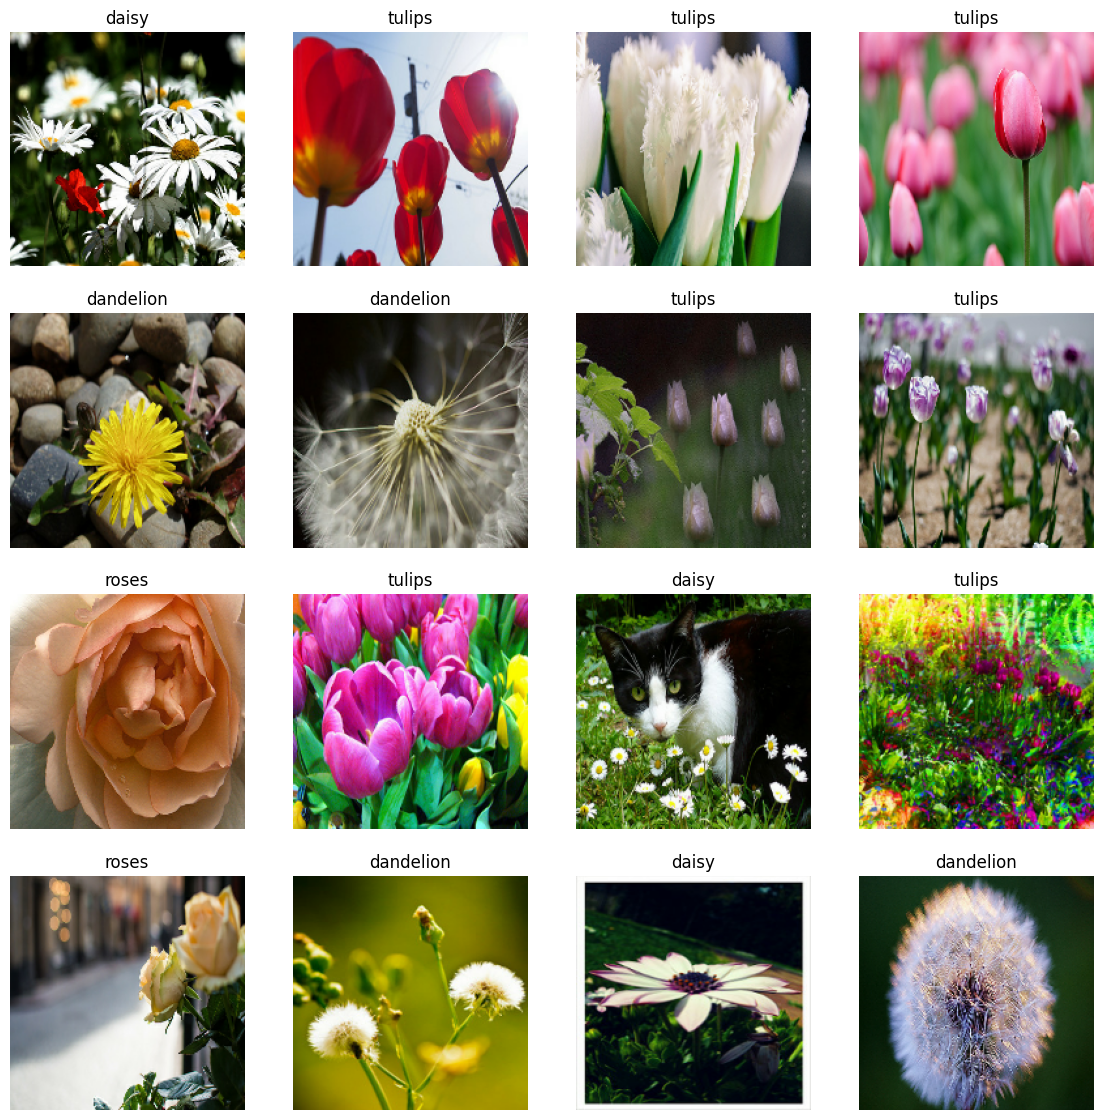

In [ ]:
plt.figure(figsize=(14,14))

for img, lbl in training_data.take(1):
  #loop through 16 images
  for idx in range(16):
    plt.subplot(4,4,idx+1)
    plt.imshow(img[idx].numpy().astype('uint8')) #Unsigned integer
    plt.axis('off')
    plt.title(flower_classes[lbl[idx]])

## Preprocessing, Normalization, and Performance Optimization

- Use `AUTOTUNE` util to allow the input pipeline to automatically tune the number of parallel processes (for performance improvement)
- `cache` for memory optimization
- `shuffle` for randomness and fair distribution

In [ ]:
AT = data.AUTOTUNE

In [ ]:
#performance optimization
training_data = training_data.cache().shuffle(1000).prefetch(buffer_size=AT)
testing_data = testing_data.cache().shuffle(1000).prefetch(buffer_size=AT)

In [ ]:
#normalization  - applied as a layer in the NN
normalization_layer = layers.Rescaling(1.0/255.0)


### Data Augmentation

In [ ]:
data_aug_layers = Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(0.12),
     layers.RandomZoom(0.08)

     ]
)

- Input Layer
- Aug Layer
- Normalization Layer
- Convolutional Layer 1 (32 filters) - apply padding
- MaxPool
- Convolutional Layer 2 (64 filters) - apply padding
- MaxPool
- Convolutional Layer 3 (128 filters) - apply padding
- MaxPool and Dropout
- Fully Connected Layer:
  - Input layer with flatten
  - Hidden layer 1 - Dense 1000
  - Hidden layer 2 - Dense 800
  - Output layer - Dense 5




In [ ]:
cnn_model = Sequential(
                    [
                        layers.Input(shape=(imgs_h, imgs_w, 3)),
                        data_aug_layers,
                        normalization_layer,
                        layers.Conv2D(32, (3,3), activation='relu', padding='same'), #with padding

                        layers.MaxPool2D(),
                        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
                        layers.MaxPool2D(),
                        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
                        layers.MaxPool2D(),
                        layers.Dropout(.15),
                        #fully connected layer
                        layers.Flatten(),
                        layers.Dense(1000, activation='relu'),
                        layers.Dense(800, activation='relu'),
                        layers.Dense(5)
                     ]

)

In [ ]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │      61,953,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 800)                 │         800,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           4,005 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,851,053 (239.76 MB)

 Trainable params: 62,851,053 (239.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True)
opt_alg = 'adam'

cnn_model.compile(optimizer=opt_alg,
                  loss=loss_fn,
                  metrics=['accuracy'])


In [ ]:
epoch_num = 40

model_hist = cnn_model.fit(training_data, validation_data=testing_data, batch_size=32, epochs=epoch_num)

Epoch 1/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.4912 - loss: 1.1657 - val_accuracy: 0.5763 - val_loss: 1.0740
Epoch 2/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.5887 - loss: 1.0047 - val_accuracy: 0.5831 - val_loss: 1.0035
Epoch 3/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.6348 - loss: 0.9241 - val_accuracy: 0.6267 - val_loss: 0.9241
Epoch 4/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6419 - loss: 0.8870 - val_accuracy: 0.6540 - val_loss: 0.8580
Epoch 5/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.6718 - loss: 0.8400 - val_accuracy: 0.6540 - val_loss: 0.8459
Epoch 6/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.7029 - loss: 0.7766 - val_accuracy: 0.6839 - val_loss: 0.8343
Epoch 7/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7091 - loss: 0.7555 - val_accuracy: 0.6948 - val_loss: 0.7604
Epoch 8/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.7092 - loss: 0.7125 - val_accuracy: 0.6975 

In [ ]:
plt.style.use('bmh')

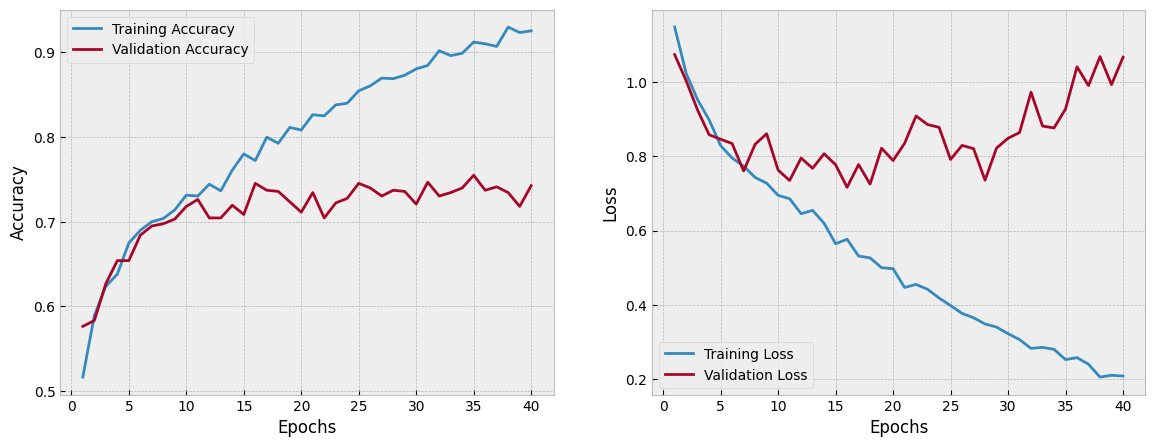

In [ ]:
fig, (plt1, plt2) = plt.subplots(1,2, figsize=(14,5))
epoch_axis_va = range(1,epoch_num+1)

#accuracy plot
plt1.plot(epoch_axis_va,model_hist.history['accuracy'], label='Training Accuracy')
plt1.plot(epoch_axis_va,model_hist.history['val_accuracy'], label='Validation Accuracy')
plt1.set_xlabel('Epochs')
plt1.set_ylabel('Accuracy')
plt1.legend()

plt2.plot(epoch_axis_va,model_hist.history['loss'], label='Training Loss')
plt2.plot(epoch_axis_va,model_hist.history['val_loss'], label='Validation Loss')
plt2.set_xlabel('Epochs')
plt2.set_ylabel('Loss')
plt2.legend()

We're clearly having overfitting. To reduce it, we can consider:
1. Increasing the training data
2. Apply regularization
3. Increase the complexity of the neural network
4. Adjust the image augmentation